# Atlas image postprocessing

- parse labels (distinct colors) into separate channels
- other processing: e.g. translation

In [2]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
import numpy as np
import pandas as pd

from PIL import Image
from PIL import ImageOps
from PIL import ImagePalette

In [3]:
NLABELS = 18

image_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
input_curv_dir = image_base_dir + '/curv-images-jitter'
input_parc_dir = image_base_dir + '/parc-images-jitter'
output_image_base_dir = image_base_dir + '/parc-images-jitter-processed'
output_curv_dir = output_image_base_dir + '/curv'
output_parc_dir = output_image_base_dir + '/parc'

os.makedirs(output_image_base_dir, exist_ok=True)
os.makedirs(output_curv_dir, exist_ok=True)
os.makedirs(output_parc_dir, exist_ok=True)

img_fps = os.listdir(input_curv_dir)

In [4]:
img_fps_curv = [f for f in img_fps if 'curv' in f]
img_fps_parc = [f for f in img_fps if 'parc' in f]

In [5]:
# same parameters for all images
def crop(image):
    """ Cropping helper function.
        Assumes input has correct y dimensions and
        x dim >= y dim; trims excess x dim to make a square.
    """
    x0, y0 = image.size   
    diff = (x0 - y0) / 2
    xl, xr = diff, x0 - diff
    ltrb = (xl, 0, xr, y0)
    return image.crop(ltrb)

def resize(image, newsize=256):
    return image.resize((newsize, newsize))

def process(image, newsize=256, grayscale=True):
    """Crops image, resizes, and converts to grayscale."""
    image = crop(image)
    image = resize(image, newsize)
    if grayscale:
        image = ImageOps.grayscale(image)
    return image

In [6]:
def get_closest_color(col, pal):
    return np.abs(col - pal).sum(axis=1).argmin()

In [7]:
def to_channel_img(img, pal):
    """ Converts an image into an image with one scalar value
        for each color in a specified palette. Each pixel's
        value is determined to be the index (in the palette)
        of the color that is closest to the pixel's original
        value.
        
        Note: expects image in RGBA PNG format, e.g. image
        shape should be (x_len, y_len, 4)).
    """
    img_np = np.array(img)
    img_colors = img_np[:, :, :-1] # remove alpha channel
    s = img_np.shape  
    ret_img = np.zeros(s[:-1])
    e = np.eye(pal.shape[0])

    # loop over pixels
    for x in range(s[0]):
        for y in range(s[1]):
            px_color = img_colors[x, y]
            cc = get_closest_color(px_color, pal)
            ret_img[x, y] = cc
    return ret_img
    

In [8]:
def process_img(img_fp, pal, img_out_fp=None, newsize=256):
    """ Downsamples an image, converts it to a numpy array,
        resamples each pixel color to nearest color
        in a specified palette (pal),
        and saves the result as a numpy array.
        Arguments:
            img_fp: full filepath to an RGBA image
            pal: palette to resample to (np array of shape (nclrs, 3))
            img_out_fp: if None, output is not saved
            newsize: size to resize to (image should be square)
        Returns:
            the resulting np array of shape (newsize, newsize,)
            with values in the range 0, pal.shape[0] - 1
    """
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img_channel = to_channel_img(img, pal)
    
    # save (optionally)
    if img_out_fp is not None:
        np.save(img_out_fp, img_channel)
    
    return img_channel

In [9]:
for f in img_fps_parc[:1]:
    img_fp = f'{input_image_dir}/{f}'
    out_fname = f[:-4]
    out_fp = f'{output_parc_dir}/{out_fname}'
    process_img(img_fp, pal, img_out_fp=out_fp)

In [10]:
# test_img_fromarray = Image.fromarray((255/19)*test_img_channel)

In [11]:
# testing
# test_img_fromarray.getcolors()
# test_img_fromarray.convert(mode='L')

In [12]:
def process_curv(img_fp, newsize=256, img_out_fp=None):
    """Crops image, resizes, and converts to grayscale."""
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img = ImageOps.grayscale(img)
    img_np = np.array(img)
    if img_out_fp is not None:
        np.save(img_out_fp, img_np)
    return img_np

In [13]:
f'{input_curv_dir}/{img_fps_curv[0]}'

'/scratch/groups/jyeatman/samjohns-projects/data/curv-images-jitter/sub-NDARUC771VM5-219.71-82.94-curv.png'

In [14]:
out_parcs = os.listdir(output_parc_dir)

In [15]:
out_parc_shapes = []
for i, p in enumerate(out_parcs):
    onp = np.load(f'{output_parc_dir}/{p}')
    out_parc_shapes.append(onp.shape)
    del onp
    if i % 500 == 0:
        print(f'loaded {i} shapes')

loaded 0 shapes
loaded 500 shapes
loaded 1000 shapes
loaded 1500 shapes
loaded 2000 shapes


KeyboardInterrupt: 

In [25]:
len(out_parcs), len(out_parc_shapes)

(91945, 91945)

In [27]:
ds = pd.DataFrame({'np_fn': out_parcs, 'sh': out_parc_shapes})

In [29]:
ds.head()

,np_fn,sh
0,sub-NDARMX277VHC-206.24-84.84-parc.npy,"(256, 256)"
1,sub-NDARCX021XWF-210.71-101.35-parc.npy,"(256, 256)"
2,sub-NDAREZ416XDW-208.13-88.33-parc.npy,"(256, 256)"
3,sub-NDARYU290HJ3-212.03-98.51-parc.npy,"(256, 256)"
4,sub-NDARYY218LU2-212.34-96.85-parc.npy,"(256, 256)"


In [28]:
ds[ds.sh==(21, 256, 256)]

,np_fn,sh


In [22]:
shapes = [p.shape for p in out_parc_nps]

In [15]:
len(os.listdir(output_curv_dir))

90441

In [9]:
for i, f in enumerate(img_fps_curv[40800:]):
    img_fp = f'{input_curv_dir}/{f}'
    out_fname = f[:-4]
    out_fp = f'{output_curv_dir}/{out_fname}'
    process_curv(img_fp, img_out_fp=out_fp)
    if i > 0 and i % 100 == 0:
        print(f'Processed {i} curvature images...')

Processed 100 curvature images...
Processed 200 curvature images...
Processed 300 curvature images...
Processed 400 curvature images...
Processed 500 curvature images...
Processed 600 curvature images...
Processed 700 curvature images...
Processed 800 curvature images...
Processed 900 curvature images...
Processed 1000 curvature images...
Processed 1100 curvature images...
Processed 1200 curvature images...
Processed 1300 curvature images...
Processed 1400 curvature images...
Processed 1500 curvature images...
Processed 1600 curvature images...
Processed 1700 curvature images...
Processed 1800 curvature images...
Processed 1900 curvature images...
Processed 2000 curvature images...
Processed 2100 curvature images...
Processed 2200 curvature images...
Processed 2300 curvature images...
Processed 2400 curvature images...
Processed 2500 curvature images...
Processed 2600 curvature images...
Processed 2700 curvature images...
Processed 2800 curvature images...
Processed 2900 curvature imag

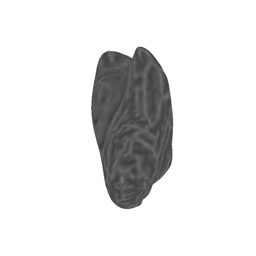

In [73]:
test_np = np.load(out_fp+'.npy')
img_test = Image.fromarray(test_np)
img_test.convert(mode='RGB')

In [ ]:
"""
Loading and plotting of a cortical surface atlas
=================================================

The Destrieux parcellation (Destrieux et al, 2010) in fsaverage5 space as
distributed with Freesurfer is used as the chosen atlas.

The :func:`nilearn.plotting.plot_surf_roi` function is used
to plot the parcellation on the pial surface.

See :ref:`plotting` for more details.

References
----------

Destrieux et al, (2010). Automatic parcellation of human cortical gyri and
sulci using standard anatomical nomenclature. NeuroImage, 53, 1.
URL http://dx.doi.org/10.1016/j.neuroimage.2010.06.010.
"""

###############################################################################
# Data fetcher
# ------------

# Retrieve destrieux parcellation in fsaverage5 space from nilearn
from nilearn import datasets

destrieux_atlas = datasets.fetch_atlas_surf_destrieux()

# The parcellation is already loaded into memory
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# The fsaverage dataset contains file names pointing to the file locations
print('Fsaverage5 pial surface of left hemisphere is at: %s' %
      fsaverage['pial_left'])
print('Fsaverage5 inflated surface of left hemisphere is at: %s' %
      fsaverage['infl_left'])
print('Fsaverage5 sulcal depth map of left hemisphere is at: %s' %
      fsaverage['sulc_left'])

###############################################################################
# Visualization
# -------------

# Display Destrieux parcellation on fsaverage5 pial surface using nilearn
from nilearn import plotting

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation,
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)

###############################################################################
# Display Destrieux parcellation on inflated fsaverage5 surface
plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=parcellation,
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)

###############################################################################
# Display Destrieux parcellation with different views: posterior
plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=parcellation,
                       hemi='left', view='posterior',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)

###############################################################################
# Display Destrieux parcellation with different views: ventral
plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=parcellation,
                       hemi='left', view='ventral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)
plotting.show()

###############################################################################
# Display Destrieux parcellation with custom view: explicitly set angle
elev, azim = 210.0, 90.0  # appropriate for visualizing, e.g., the OTS
plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=parcellation,
                       hemi='left', view=(elev, azim),
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)